# Examples

This Jupyter notebook shows some examples for the different functions of the Julia module `zaf`.

Functions:
- [`stft`](#stft) - Compute the short-time Fourier transform (STFT).
- [`istft`](#istft) - Compute the inverse STFT.
- [`melfilterbank`](#melfilterbank) - Compute the mel filterbank.
- [`melspectrogram`](#melspectrogram) - Compute the mel spectrogram using a mel filterbank.
- [`mfcc`](#mfcc) - Compute the mel-frequency cepstral coefficients (MFCCs) using a mel filterbank.
- [`cqtkernel`](#cqtkernel) - Compute the constant-Q transform (CQT) kernel.
- [`cqtspectrogram`](#cqtspectrogram) - Compute the CQT spectrogram using a CQT kernel.
- [`cqtchromagram`](#cqtchromagram) - Compute the CQT chromagram using a CQT kernel.
- [`dct`](#dct) - Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).
- [`dst`](#dst) - Compute the discrete sine transform (DST) using the FFT.
- [`mdct`](#mdct) - Compute the modified discrete cosine transform (MDCT) using the FFT.
- [`imdct`](#imdct) - Compute the inverse MDCT using the FFT.

Other:
- `hamming` - Compute the Hamming window.
- `sigplot` - Plot a signal in seconds.
- `specshow` - Display a spectrogram in dB, seconds, and Hz.
- `melspecshow` - Display a mel spectrogram in dB, seconds, and Hz.
- `mfccshow` - Display MFCCs in seconds.
- `cqtspecshow` - Display a CQT spectrogram in dB, seconds, and Hz.
- `cqtchromshow` - Display a CQT chromagram in seconds.


Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 04/08/21

## <a id="stft"></a>stft

Compute the short-time Fourier transform (STFT).

```
audio_stft = zaf.stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_stft: audio STFT (window_length, number_frames)
```

### Example: Compute and display the spectrogram from an audio file.

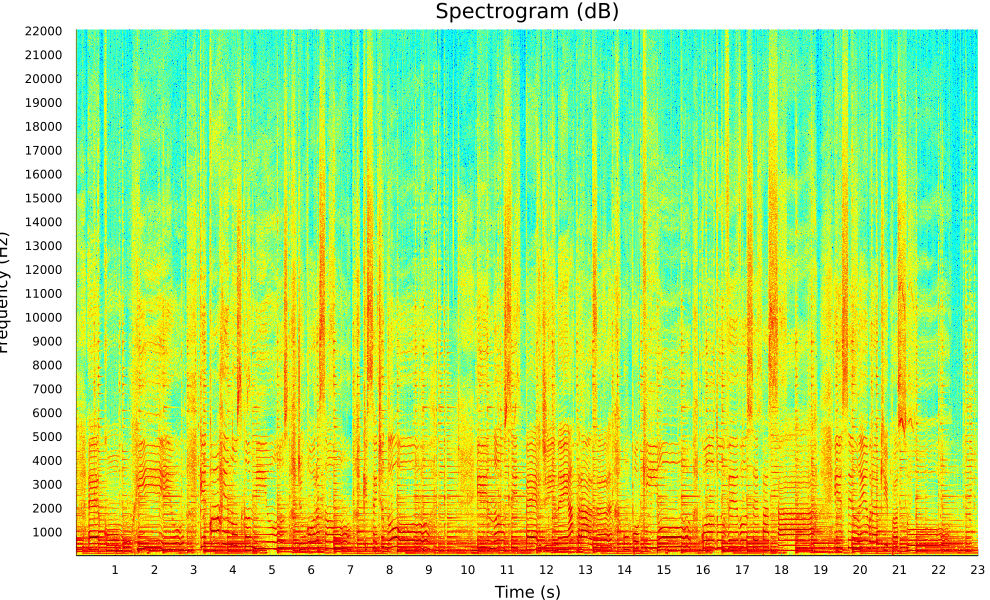

In [1]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04

# Derive the window length in samples (use powers of 2 for faster FFT and constant overlap-add (COLA))
window_length = nextpow(2, ceil(Int, window_duration*sampling_frequency))

# Compute the window function (periodic Hamming window for COLA)
window_function = zaf.hamming(window_length, "periodic")

# Set the step length in samples (half of the window length for COLA)
step_length = convert(Int, window_length/2)

# Compute the STFT
audio_stft = zaf.stft(audio_signal, window_function, step_length)

# Derive the magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = abs.(audio_stft[2:convert(Int, window_length/2)+1, :])

# Display the spectrogram in dB, seconds, and Hz
xtick_step = 1
ytick_step = 1000
plot_object = zaf.specshow(audio_spectrogram, length(audio_signal), sampling_frequency, xtick_step, ytick_step)
heatmap!(title = "Spectrogram (dB)", size = (990, 600))

## <a id="istft"></a>istft

Compute the inverse short-time Fourier transform (STFT).

```
audio_signal = zaf.istft(audio_stft, window_function, step_length)

Inputs:
    audio_stft: audio STFT (window_length, number_frames)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_signal: audio signal (number_samples,)
```

### Example: Estimate the center and the sides from a stereo audio file.

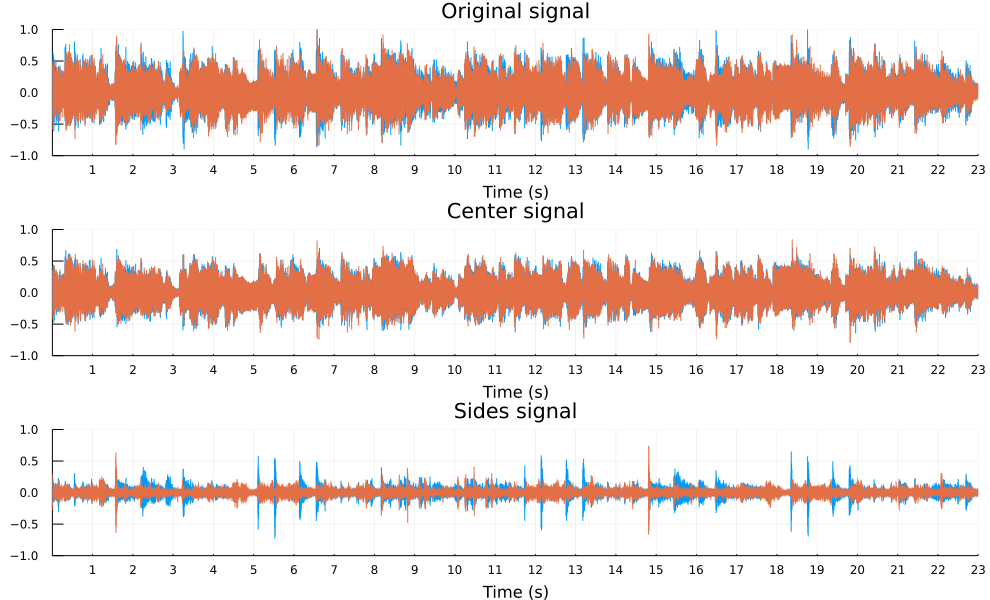

In [2]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Plots

# Read the (stereo) audio signal with its sampling frequency in Hz
audio_signal, sampling_frequency = wavread("audio_file.wav")

# Set the parameters for the STFT
window_length = nextpow(2, ceil(Int, 0.04*sampling_frequency))
window_function = zaf.hamming(window_length, "periodic")
step_length = convert(Int, window_length/2)

# Compute the STFTs for the left and right channels
audio_stft1 = zaf.stft(audio_signal[:,1], window_function, step_length)
audio_stft2 = zaf.stft(audio_signal[:,2], window_function, step_length)

# Derive the magnitude spectrograms (with DC component) for the left and right channels
audio_spectrogram1 = abs.(audio_stft1[1:convert(Int, window_length/2)+1, :])
audio_spectrogram2 = abs.(audio_stft2[1:convert(Int, window_length/2)+1, :])

# Estimate the time-frequency masks for the left and right channels for the center
center_mask1 = min.(audio_spectrogram1, audio_spectrogram2)./audio_spectrogram1
center_mask2 = min.(audio_spectrogram1, audio_spectrogram2)./audio_spectrogram2

# Derive the STFTs for the left and right channels for the center (with mirrored frequencies)
center_stft1 = [center_mask1; center_mask1[convert(Int, window_length/2):-1:2,:]] .* audio_stft1
center_stft2 = [center_mask2; center_mask2[convert(Int, window_length/2):-1:2,:]] .* audio_stft2

# Synthesize the signals for the left and right channels for the center
center_signal1 = zaf.istft(center_stft1, window_function, step_length)
center_signal2 = zaf.istft(center_stft2, window_function, step_length)

# Derive the final stereo center and sides signals
center_signal = [center_signal1 center_signal2];
center_signal = center_signal[1:size(audio_signal, 1), :]
sides_signal = audio_signal-center_signal;

# Write the center and sides signals
wavwrite(center_signal, "center_signal.wav", Fs=sampling_frequency)
wavwrite(sides_signal, "sides_signal.wav", Fs=sampling_frequency)

# Display the original, center, and sides signals in seconds
xtick_step = 1
plot_object1 = zaf.sigplot(audio_signal, sampling_frequency, xtick_step)
plot!(ylims = (-1, 1), title = "Original signal")
plot_object2 = zaf.sigplot(center_signal, sampling_frequency, xtick_step)
plot!(ylims = (-1, 1), title = "Center signal")
plot_object3 = zaf.sigplot(sides_signal, sampling_frequency, xtick_step)
plot!(ylims = (-1, 1), title = "Sides signal")
plot(plot_object1, plot_object2, plot_object3, layout = (3, 1), size = (990, 600))

## <a id="melfilterbank"></a>melfilterbank

Compute the mel filterbank.

```
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_filters)

Inputs:
    sampling_frequency: sampling frequency in Hz
    window_length: window length for the Fourier analysis in samples
    number_mels: number of mel filters
Output:
    mel_filterbank: mel filterbank (number_mels, number_frequencies)
```

### Example: Compute and display a mel filterbank.

In [ ]:
# Compute the mel filterbank using some parameters
sampling_frequency = 44100;
window_length = 2^nextpow2(0.04*sampling_frequency);
number_mels = 128;
mel_filterbank = zaf.melfilterbank(sampling_frequency,window_length,number_mels);

## <a id="melspectrogram"></a>melspectrogram

Compute the mel spectrogram using a mel filterbank.

```
mel_spectrogram = zaf.melspectrogram(audio_signal, mel_filterbank)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
    mel_filterbank: mel filterbank (number_mels, number_frequencies)
Output:
    mel_spectrogram: mel spectrogram (number_mels, number_times)
```

### Example: Compute and display the mel spectrogram.

## <a id="mfcc"></a>mfcc

Compute the mel-frequency cepstral coefficients (MFCCs) using a mel filterbank.

```
audio_mfcc = zaf.mfcc(audio_signal, window_function, step_length, mel_filterbank, number_coefficients)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
    mel_filterbank: mel filterbank (number_mels, number_frequencies)
    number_coefficients: number of coefficients (without the 0th coefficient)
Output:
    audio_mfcc: audio MFCCs (number_times, number_coefficients)
```

### Example: Compute and display the MFCCs, delta MFCCs, and delta-detla MFCCs.

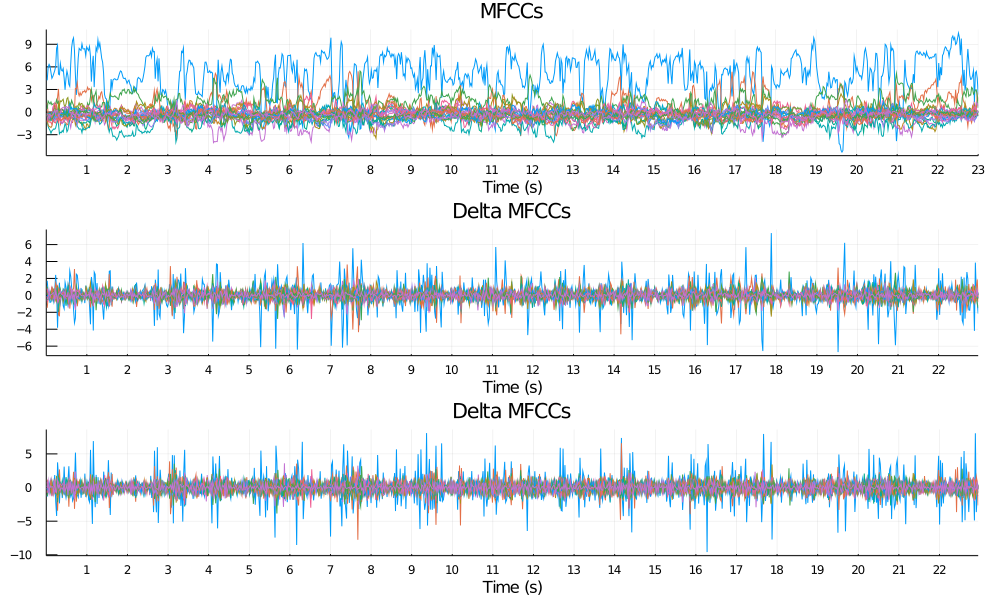

In [6]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Compute the MFCCs with a given number of filters and coefficients
number_filters = 40
number_coefficients = 20
audio_mfcc = zaf.mfcc(audio_signal, sampling_frequency, number_filters, number_coefficients)

# Compute the delta and delta-delta MFCCs
audio_dmfcc = diff(audio_mfcc, dims=2)
audio_ddmfcc = diff(audio_dmfcc, dims=2)

# Compute the time resolution for the MFCCs in number of time frames per second (~ sampling frequency for the MFCCs)
time_resolution = sampling_frequency*size(audio_mfcc, 2)/length(audio_signal)

# Display the MFCCs, delta MFCCs, and delta-delta MFCCs in seconds
xtick_step = 1
plot_object1 = zaf.sigplot(transpose(audio_mfcc), time_resolution, xtick_step); plot!(title = "MFCCs")
plot_object2 = zaf.sigplot(transpose(audio_dmfcc), time_resolution, xtick_step); plot!(title = "Delta MFCCs")
plot_object3 = zaf.sigplot(transpose(audio_ddmfcc), time_resolution, xtick_step); plot!(title = "Delta MFCCs")
plot(plot_object1, plot_object2, plot_object3, layout = (3, 1), size = (990, 600))

## <a id="cqtkernel"></a>cqtkernel

Compute the constant-Q transform (CQT) kernel.

```
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

Inputs:
    sampling_frequency: sampling frequency in Hz
    frequency_resolution: frequency resolution in number of frequency channels per semitone
    minimum_frequency: minimum frequency in Hz
    maximum_frequency: maximum frequency in Hz
Output:
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
```

### Example: Compute and display a CQT kernel.

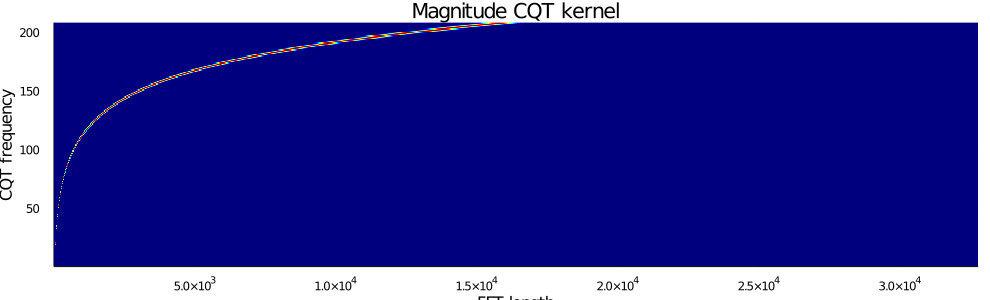

In [3]:
# Load the modules
include("./zaf.jl")
using .zaf
using Plots

# Set the parameters for the CQT kernel
sampling_frequency = 44100
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = sampling_frequency/2

# Compute the CQT kernel
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

# Display the magnitude CQT kernel
heatmap(abs.(Array(cqt_kernel)), fillcolor = :jet, legend = false, fmt = :png, size = (990, 300), 
    title = "Magnitude CQT kernel", xlabel = "FFT length", ylabel = "CQT frequency")

## <a id="cqtspectrogram"></a>cqtspectrogram

Compute the constant-Q transform (CQT) spectrogram using a kernel.

```
audio_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    time_resolution: time resolution in number of time frames per second
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
Output:
    audio_spectrogram: magnitude audio spectrogram (number_frequencies, number_times)
```

### Example: Compute and display the CQT spectrogram.

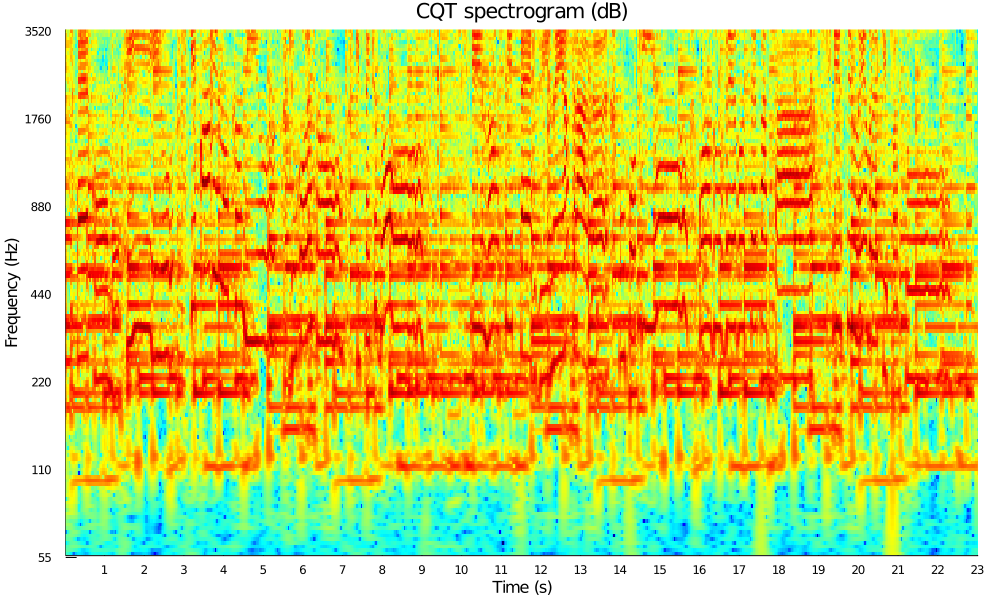

In [4]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Compute the CQT kernel using some parameters
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

# Compute the (magnitude) CQT spectrogram using the kernel
time_resolution = 25
audio_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

# Display the CQT spectrogram in dB, seconds, and Hz
xtick_step = 1
plot_object = zaf.cqtspecshow(audio_spectrogram, time_resolution, frequency_resolution, minimum_frequency, xtick_step)
heatmap!(title = "CQT spectrogram (dB)", size = (990, 600))

## <a id="cqtchromagram"></a>cqtchromagram

Compute the constant-Q transform (CQT) chromagram using a kernel.

```
audio_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, frequency_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    time_resolution: time resolution in number of time frames per second
    frequency_resolution: frequency resolution in number of frequency channels per semitones
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
Output:
    audio_chromagram: audio chromagram (number_chromas, number_times)
```

### Example: Compute and display the CQT chromagram.

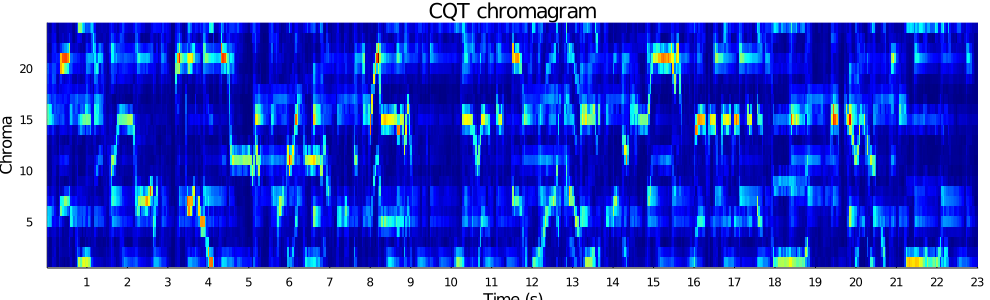

In [5]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Compute the CQT kernel using some parameters
frequency_resolution = 2
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = zaf.cqtkernel(sampling_frequency, frequency_resolution, minimum_frequency, maximum_frequency)

# Compute the CQT chromagram
time_resolution = 25
audio_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, frequency_resolution, cqt_kernel)

# Display the CQT chromagram in seconds
xtick_step = 1
plot_object = zaf.cqtchromshow(audio_chromagram, time_resolution, xtick_step)
heatmap!(title = "CQT chromagram", size = (990, 300))

## <a id="dct"></a>dct

Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).

```
audio_dct = zaf.dct(audio_signal, dct_type)

Inputs:
    audio_signal: audio signal (window_length,)
    dct_type: dct type (1, 2, 3, or 4)
Output:
    audio_dct: audio DCT (number_frequencies,)
```

### Example: Compute the 4 different DCTs and compare them to FFTW's DCTs.

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283


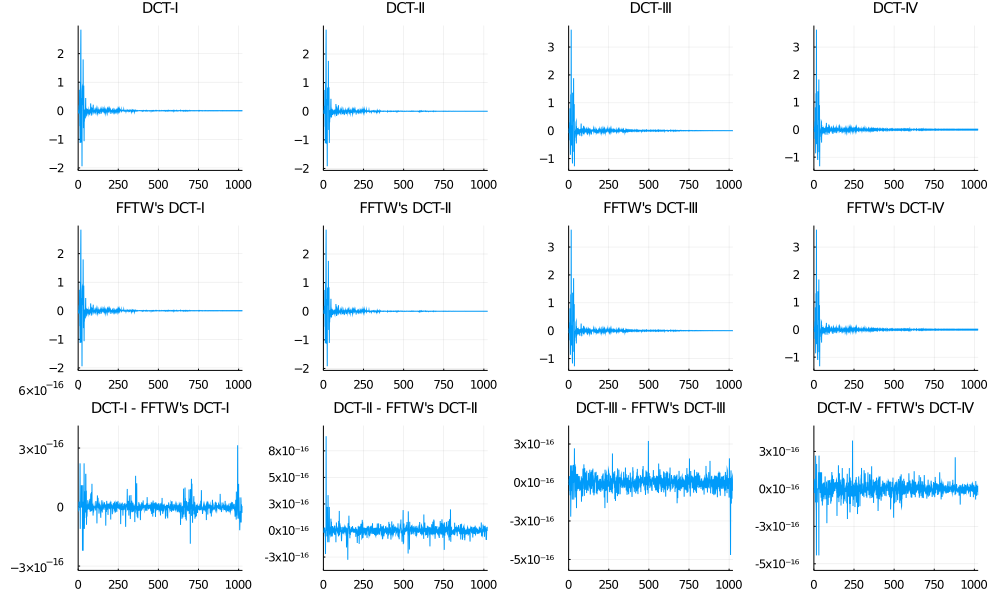

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283


In [7]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using FFTW
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Get an audio segment for a given window length
window_length = 1024
audio_segment = audio_signal[1:window_length]

# Compute the DCT-I, II, III, and IV
audio_dct1 = zaf.dct(audio_segment, 1)
audio_dct2 = zaf.dct(audio_segment, 2)
audio_dct3 = zaf.dct(audio_segment, 3)
audio_dct4 = zaf.dct(audio_segment, 4)

# Compute FFTW's DCT-I, II, III, and IV (orthogonalized)
audio_segment2 = copy(audio_segment)
audio_segment2[[1, end]] = audio_segment2[[1, end]]*sqrt(2)
fftw_dct1 = FFTW.r2r(audio_segment2, FFTW.REDFT00)
fftw_dct1[[1, window_length]] = fftw_dct1[[1, window_length]]/sqrt(2)
fftw_dct1 = fftw_dct1/2 * sqrt(2/(window_length - 1))

fftw_dct2 = FFTW.r2r(audio_segment, FFTW.REDFT10)
fftw_dct2[1] = fftw_dct2[1]/sqrt(2)
fftw_dct2 = fftw_dct2/2 * sqrt(2/window_length)

audio_segment2 = copy(audio_segment)
audio_segment2[1] = audio_segment2[1]*sqrt(2)
fftw_dct3 = FFTW.r2r(audio_segment2, FFTW.REDFT01)
fftw_dct3 = fftw_dct3/2 * sqrt(2/window_length)

fftw_dct4 = FFTW.r2r(audio_segment, FFTW.REDFT11)
fftw_dct4 = fftw_dct4/2 * sqrt(2/window_length)

# Plot the DCT-I, II, III, and IV, FFTW's versions, and their differences (using yformatter because of precision issue in ticks)
dct1_plot = plot(audio_dct1, title = "DCT-I")
dct2_plot = plot(audio_dct2, title = "DCT-II")
dct3_plot = plot(audio_dct3, title = "DCT-III")
dct4_plot = plot(audio_dct4, title = "DCT-IV")
dct1_plot2 = plot(fftw_dct1, title = "FFTW's DCT-I")
dct2_plot2 = plot(fftw_dct2, title = "FFTW's DCT-II")
dct3_plot2 = plot(fftw_dct3, title = "FFTW's DCT-III")
dct4_plot2 = plot(fftw_dct4, title = "FFTW's DCT-IV")
diff1_plot = plot(audio_dct1-fftw_dct1, title = "DCT-I - FFTW's DCT-I")
diff2_plot = plot(audio_dct2-fftw_dct2, title = "DCT-II - FFTW's DCT-II", yformatter = y->string(convert(Int, round(y/1e-16)),"x10⁻¹⁶"))
diff3_plot = plot(audio_dct3-fftw_dct3, title = "DCT-III - FFTW's DCT-III", yformatter = y->string(convert(Int, round(y/1e-16)),"x10⁻¹⁶"))
diff4_plot = plot(audio_dct4-fftw_dct4, title = "DCT-IV - FFTW's DCT-IV", yformatter = y->string(convert(Int, round(y/1e-16)),"x10⁻¹⁶"))
plot(dct1_plot, dct2_plot, dct3_plot, dct4_plot, dct1_plot2, dct2_plot2, dct3_plot2, dct4_plot2, 
    diff1_plot, diff2_plot, diff3_plot, diff4_plot, xlims = (0, window_length), legend = false, titlefont = 10, 
    layout = (3,4), size = (990, 600), fmt = :png)

## <a id="dst"></a>dst

Compute the discrete sine transform (DST) using the fast Fourier transform (FFT).

```
audio_dst = zaf.dst(audio_signal, dst_type)

Inputs:
    audio_signal: audio signal (window_length,)
    dst_type: DST type (1, 2, 3, or 4)
Output:
    audio_dst: audio DST (number_frequencies,)
```

### Example: Compute the 4 different DSTs and compare their respective inverses with the original audio.

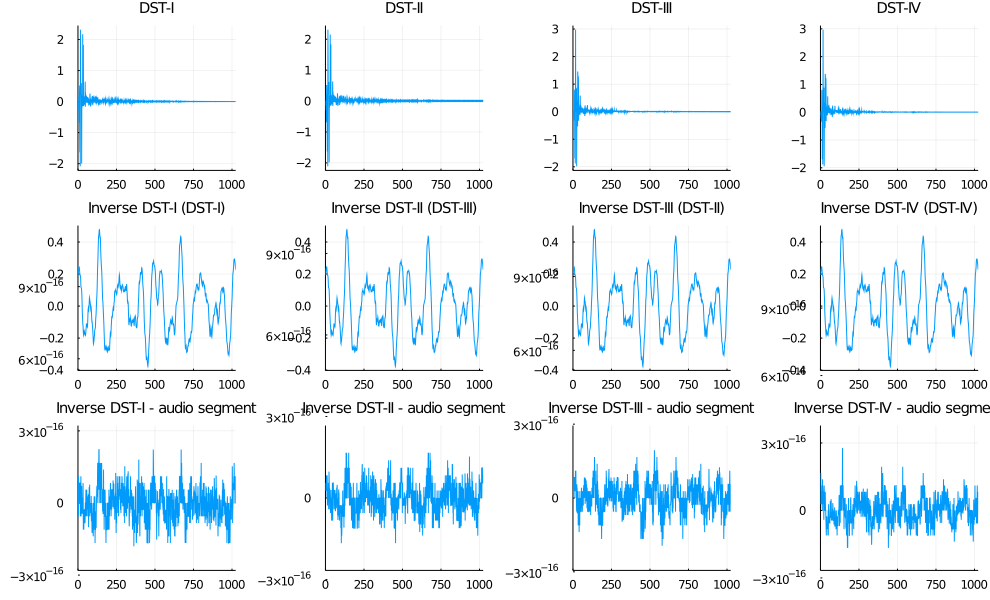

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\raza7002\.julia\packages\PlotUtils\3Ttrk\src\ticks.jl:283


In [8]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Get an audio segment for a given window length
window_length = 1024
audio_segment = audio_signal[1:window_length]

# Compute the DST-I, II, III, and IV
audio_dst1 = zaf.dst(audio_segment, 1)
audio_dst2 = zaf.dst(audio_segment, 2)
audio_dst3 = zaf.dst(audio_segment, 3)
audio_dst4 = zaf.dst(audio_segment, 4)

# Compute their respective inverses, i.e., DST-I, II, III, and IV
audio_idst1 = zaf.dst(audio_dst1, 1)
audio_idst2 = zaf.dst(audio_dst2, 3)
audio_idst3 = zaf.dst(audio_dst3, 2)
audio_idst4 = zaf.dst(audio_dst4, 4)

# Plot the DST-I, II, III, and IV, their respective inverses, and their differences with the original audio segment
dst1_plot = plot(audio_dst1, title = "DST-I");
dst2_plot = plot(audio_dst2, title = "DST-II");
dst3_plot = plot(audio_dst3, title = "DST-III");
dst4_plot = plot(audio_dst4, title = "DST-IV");
idst1_plot2 = plot(audio_idst1, title = "Inverse DST-I (DST-I)")
idst2_plot2 = plot(audio_idst2, title = "Inverse DST-II (DST-III)")
idst3_plot2 = plot(audio_idst3, title = "Inverse DST-III (DST-II)")
idst4_plot2 = plot(audio_idst4, title = "Inverse DST-IV (DST-IV)")
diff1_plot = plot(audio_idst1-audio_segment, title = "Inverse DST-I - audio segment")
diff2_plot = plot(audio_idst2-audio_segment, title = "Inverse DST-II - audio segment")
diff3_plot = plot(audio_idst3-audio_segment, title = "Inverse DST-III - audio segment")
diff4_plot = plot(audio_idst4-audio_segment, title = "Inverse DST-IV - audio segment")
plot(dst1_plot, dst2_plot, dst3_plot, dst4_plot, idst1_plot2, idst2_plot2, idst3_plot2, idst4_plot2, 
    diff1_plot, diff2_plot, diff3_plot, diff4_plot, xlims = (0, window_length), legend = false, titlefont = 10, 
    layout = (3,4), size = (990, 600), fmt = :png)

## <a id="mdct"></a>mdct

Compute the modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT).

```
audio_mdct = zaf.mdct(audio_signal, window_function)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
Output:
    audio_mdct: audio MDCT (number_frequencies, number_times)
```

### Example: Compute and display the MDCT as used in the AC-3 audio coding format.

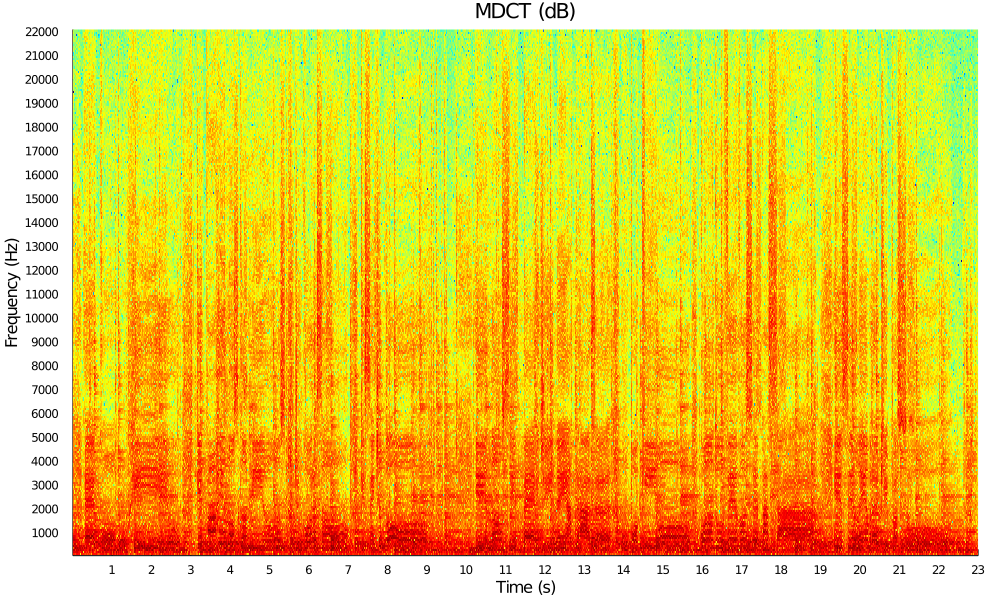

In [9]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Add and use the DSP package to get the kaiser window function
Pkg.add("DSP")
using DSP

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Compute the Kaiser-Bessel-derived (KBD) window as used in the AC-3 audio coding format
window_length = 512
alpha_value = 5
window_function = kaiser(convert(Int, window_length/2)+1, alpha_value*pi)
window_function2 = cumsum(window_function[1:convert(Int, window_length/2)])
window_function = sqrt.([window_function2; window_function2[convert(Int, window_length/2):-1:1]]./sum(window_function))

# Compute the MDCT
audio_mdct = zaf.mdct(audio_signal, window_function)

# Display the MDCT in dB, seconds, and Hz
xtick_step = 1
ytick_step = 1000
plot_object = zaf.specshow(abs.(audio_mdct), length(audio_signal), sampling_frequency, xtick_step, ytick_step)
heatmap!(title = "MDCT (dB)", size = (990, 600))

## <a id="imdct"></a>imdct

Compute the inverse modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT).

```
audio_signal = zaf.imdct(audio_mdct, window_function)

Inputs:
    audio_mdct: audio MDCT (number_frequencies, number_times)
    window_function: window function (window_length,)
Output:
    audio_signal: audio signal (number_samples,)
```

### Example: Verify that the MDCT is perfectly invertible.

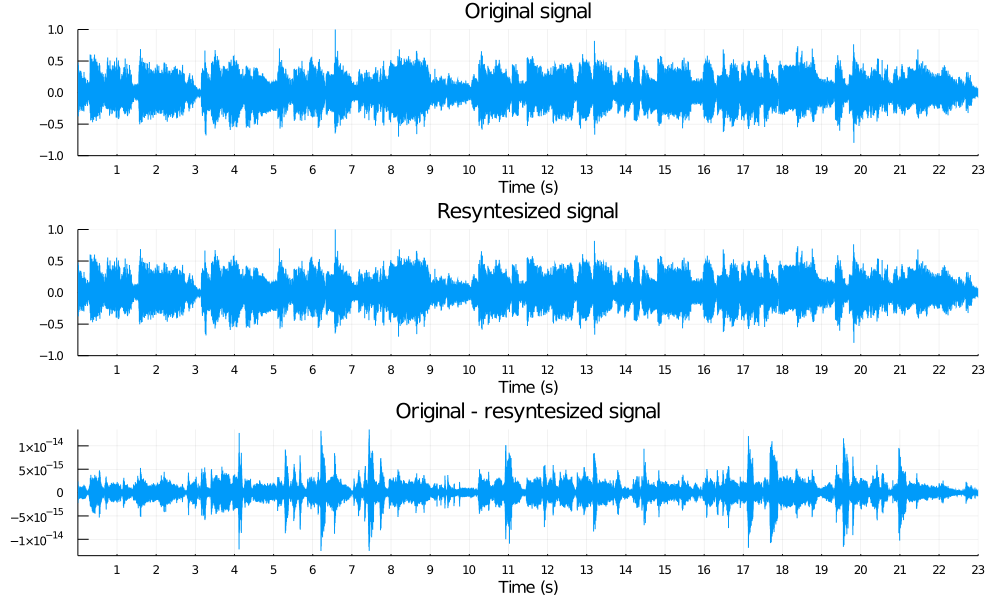

In [10]:
# Load the modules
include("./zaf.jl")
using .zaf
using WAV
using Statistics
using Plots

# Read the audio signal with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = wavread("audio_file.wav")
audio_signal = mean(audio_signal, dims=2)

# Compute the MDCT with a slope function as used in the Vorbis audio coding format
window_length = 2048
window_function = sin.(pi/2*(sin.(pi/window_length*(0.5:window_length-0.5)).^2))
audio_mdct = zaf.mdct(audio_signal, window_function)

# Compute the inverse MDCT
audio_signal2 = zaf.imdct(audio_mdct, window_function)
audio_signal2 = audio_signal2[1:length(audio_signal)]

# Compute the differences between the original signal and the resynthesized one
audio_differences = audio_signal-audio_signal2
y_max = maximum(abs.(audio_differences))

# Display the original and resynthesized signals, and their differences in seconds
xtick_step = 1
plot_object1 = zaf.sigplot(audio_signal, sampling_frequency, xtick_step)
plot!(ylims = (-1, 1), title = "Original signal")
plot_object2 = zaf.sigplot(audio_signal2, sampling_frequency, xtick_step)
plot!(ylims = (-1, 1), title = "Resyntesized signal")
plot_object3 = zaf.sigplot(audio_differences, sampling_frequency, xtick_step)
plot!(ylims = (-y_max, y_max), title = "Original - resyntesized signal")
plot(plot_object1, plot_object2, plot_object3, layout = (3, 1), size = (990, 600))